In [1]:
%matplotlib inline

# DISPERSION ANALYSIS I
Author: Jordan Guerra (for Villanova University). February 2024.

This tutorial illustrates the basic use of the package *polBpy* for performing the angular dispersion analysis for studying the magnetoturbulent state of gas using dust polarimetric observations. Parameters determined can be used for DCF calaculations. The Majority of functions for this tutorial are in the module *dipsersion*.

This tutorial uses data from literature listed [here.](https://github.com/jorgueagui/polBpy/blob/9039d4af5d25c49130bf51be7fe0ce363424edcc/refs.md)

**EXAMPLE I**: This example shows how to perform the dispersion analysis for an entire, masked region of gas. This analysis involves: i) calculating the autocorrelation function of the polarized flux ($p$), the width of this autocorrelation function is an estimate of the cloud's depnth; ii) calcualting the two-point struture function; from now on referred to as "dispersion function", iii) fitting the dispersion function with the two-scale model of Houde+2009 using a Monte-Carlo Markov Chain (MCMC) approach in order determining the magnetotubrulent parameters. We reproduce here some results from Butterfiel+2024, which presents results of the Galactic center's M0.8-0.2 ring using observations of SOFIA/HAWC+.

In [49]:
from polBpy import dispersion, fitting
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
import os
from astropy import wcs
from reproject import (reproject_interp)

The fisrt step in the dispersion analysis id to calculate the autocorrelation function. We do this using the 214 $\mu$m data from a FITS file

In [50]:
file = '/users/nsalem/Merged_Full_Polarization_Rotated.fits'
data = fits.open(file)
print(data.info())

Filename: /users/nsalem/Merged_Full_Polarization_Rotated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1490   (1900, 950)   float64   
  1  ERROR I       1 ImageHDU        19   (1900, 950)   float64   
  2  STOKES Q      1 ImageHDU        19   (1900, 950)   float64   
  3  ERROR Q       1 ImageHDU        19   (1900, 950)   float64   
  4  STOKES U      1 ImageHDU        19   (1900, 950)   float64   
  5  ERROR U       1 ImageHDU        19   (1900, 950)   float64   
  6  IMAGE MASK    1 ImageHDU        60   (1900, 950)   float64   
  7  PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
 10  POL ANGLE     1 ImageHDU        19   (1900, 950)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (1900, 950)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        19   

In [3]:
p_flux = fits.open('p_flux_clip.fits')[0].data
p_flux_err = fits.open('p_flux_err_clip.fits')[0].data
Stokes_I = fits.open('Stokes_I_clip.fits')[0].data
angles = fits.open('angles_clip.fits')[0].data
angles_err = fits.open('angles_err_clip.fits')[0].data

In [4]:
w=wcs.WCS(data[0].header)

Step 1: Define a mask. A mask must be an array of 1 and 0 values indicating if that pixel is consired in the calculations (1) or not (0). First, we define a *pixel* mask by only keeping pixels for which $p/p_{err} > 3.0$ and $I > 5000$ MJy/sr

In [5]:
#polarization vectors
#Needed for WCS scaling
def header_scale(fits, rebin):
    naxis1, naxis2 = fits[0].header['NAXIS1'], fits[0].header['NAXIS2']
    fits[0].header['NAXIS1'] = int(rebin * fits[0].header['NAXIS1'])
    fits[0].header['NAXIS2'] = int(rebin * fits[0].header['NAXIS2'])
    fits[0].header['CDELT1'] /= rebin
    fits[0].header['CDELT2'] /= rebin
    fits[0].header['CRPIX1'] = (fits[0].header['CRPIX1'] / naxis1) * fits[0].header['NAXIS1']
    fits[0].header['CRPIX2'] = (fits[0].header['CRPIX2'] / naxis2) * fits[0].header['NAXIS2']

In [51]:
#Use SOFIA map as a background image
pixsize=data[0].header['CDELT2']*3600 #picks out the plate scale and converts to arcsec/pixel
print(pixsize)
beamdiam=5.3/3600 #arcseconds
bunit=data[0].header['BUNIT']
I = data['Stokes I'].data
sigI = data['ERROR I'].data
if bunit=='Jy/pixel':
    beam_area=(float(pixsize)/3600*np.pi/180)**2 #in sr
else:
    beam_area=(float(beamdiam)/3600*np.pi/180/2)**2*np.pi #in sr
I=I/beam_area/1e6 #scale to MJy/sr here and it should follow through the analysis.
sigI=sigI/beam_area/1e6

pol, pol_err, ang = p_flux, p_flux_err, angles


4.550000000000001


In [7]:
#fixing all the polarized stuff to match the new coord system/pixel orientation
pol_fixed,_=reproject_interp((pol,w),data[0].header)
pol_error_fixed,_=reproject_interp((pol_err,w),data[0].header)
pol_ang_fixed,_=reproject_interp((ang,w),data[0].header)

I_fixed,_=reproject_interp((I,w),data[0].header)
sigI_fixed,_=reproject_interp((sigI,w),data[0].header)


In [52]:
#3 sigma threshold, SOFIA cuts as described in papers
polthresh=3
pol_fixed[np.where(pol_fixed/pol_error_fixed<polthresh)]=np.nan
pol_fixed[np.where(I_fixed/sigI_fixed<200)]=np.nan
pol_fixed[np.where(pol_fixed>50)]=np.nan


#polarization vector spacing, default 2, raise if code is slow
skip=5
aa = pol_fixed[~np.isnan(pol_fixed)]
#aa[aa > 0]
print(len(aa))
x, y = np.meshgrid(np.arange(pol_fixed.shape[1]), np.arange(pol_fixed.shape[0]))
mask=np.where((x%skip+y%skip)==0)
#apply the mask
pol2=pol_fixed[mask]
ang2=pol_ang_fixed[mask]
xnew=x[mask]
ynew=y[mask]



print(np.nanmin(ang2))
print(np.nanmax(ang2))

#Coords required for quiver
xx = pol2*np.cos(ang2*np.pi/180.)
yy = pol2*np.sin(ang2*np.pi/180.)
#print(np.nanmin(pol2))
temp1=ang2*np.pi/180.
print(np.nanmin(temp1))
print(np.nanmax(temp1))



pixel_size = data[0].header['CDELT2']*3600 # Pixel size in arcsec
beam_area=(float(pixel_size)/3600*np.pi/180)**2 # Beam area in sr
Stokes_I /= beam_area 
Stokes_I /= 1E+6 # Transforming Stokes I intensitu to MJy/sr



4656
64.66267037721437
242.85553026047046
1.1285765012141944
4.238628609721932


In [53]:
m = np.where((p_flux/p_flux_err > 3.0) & (Stokes_I > 1500.0)) 
pixel_mask = np.full_like(Stokes_I,0.0) #create array same shape as Stokes_I, fill values with 0
pixel_mask[m] = 1.0 #changes 0 to 1 if criteria are met

Text(0.5, 1.0, 'Pixel Mask')

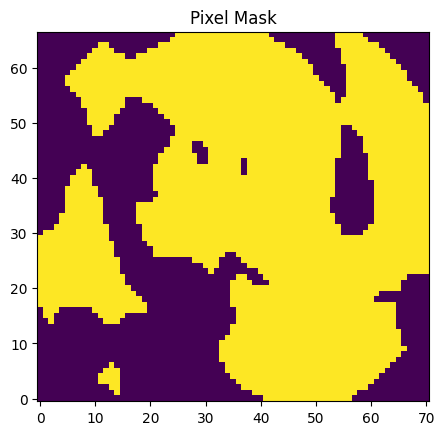

In [54]:

plt.imshow(pixel_mask,origin='lower')
plt.title('Pixel Mask')


We can also, define a *region* mask, an area to focus on a region of interest. For example, in Butterfield+24 the analysis is done including data only up to ~ 9 pc from the center of the ring. We read this data froma file for convenience,

<SkyCoord (Galactic): (l, b) in deg
    (0.005, 0.1275)>
1030.264275007312 622.3712568578787


Text(0.5, 1.0, 'Region Mask')

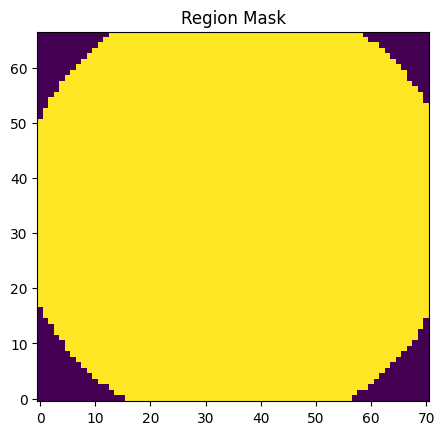

In [18]:
# CREATING ARRAYS OF COORDINATES
nx, ny = data[0].header['NAXIS1'], data[0].header['NAXIS2']
endx, endy = nx, ny
x,y = pixsize*np.linspace(0,endx,nx), pixsize*np.linspace(0,endy,ny) # IN PIXEL UNITS

# DEFINE THE CENTER OF THE SOURCE 
center = SkyCoord('0.005deg','0.1275deg',frame='galactic')
print(center)
cx,cy = w.wcs_world2pix(center.l.deg,center.b.deg,0)
print(cx,cy)

# SHIFT THE CORRDINATES TO BE CENTERED AT THE SOURCE CENTER
x += -cx*pixsize
y += -cy*pixsize
xv, yv = np.meshgrid(x,y)

# RADIAL AND AZIMUTHAL DISTANCES ARRAY
rv = np.sqrt(xv*xv + yv*yv)
theta = np.arctan2(xv,yv)
theta[theta<0.] += 2.*np.pi
theta = 2.0*np.pi - theta

# Bins of r and theta
# DEFINE R_MAX AND/OR R_MIN
rmin = 0. # IN ARCSEC
rmax = 180. # IN ARCSEC

# MASK
region_mask = np.zeros((ny,nx))
region_mask[:,:] = 1.0
m1 = np.where(rv < rmin)
region_mask[m1] = 0.0
m2 = np.where(rv > rmax)
region_mask[m2] = 0.0

# file = "PolBpy_Tutorial_III_mask.fits"
# data_mask = fits.open(file)
#print(data_mask.info())
# region_mask = data_mask[1].data
region_mask=region_mask[588:655,994:1065]
plt.imshow(region_mask,origin='lower')
plt.title('Region Mask')

Now we calculate the total as *mask = pixel_mask x region_mask*

In [15]:
pixel_mask.shape

(67, 71)

In [16]:
region_mask.shape

(67, 71)

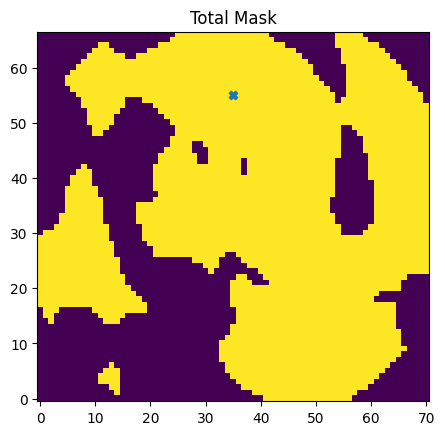

In [19]:
mask = pixel_mask*region_mask
plt.imshow(mask,origin='lower')
plt.title('Total Mask')
plt.scatter(35,55,marker='X')

Step 2: Calculating the autocorrelation function and effective depth of the cloud. When calling the autocorrelation function, we ha ve few options. Firts, in order to obtain the cloud's depth in physical units, we need to provide the pixel size in arcseconds. If not specified, the resulting $\Delta^{\prime}$ is in number of pixels. Second, if plots=True is set, the routine displays the plot of resulting autocorrelation function, for visual inspection. Third, if hwhm=True is set, the result is the half-width, half-max (HWHM) value of the autocorreltion function. Otherwise, the result is the autocorrelation function, its uncertainty values, and isotropic distance ($\ell$).

The inputs for the autocorreltion nfunction are the polarized flux, polarized flux error, total mask, and the pixel size,

In [15]:
p_flux.shape

(67, 71)

In [16]:
p_flux_err.shape

(67, 71)

In [17]:
mask.shape

(67, 71)

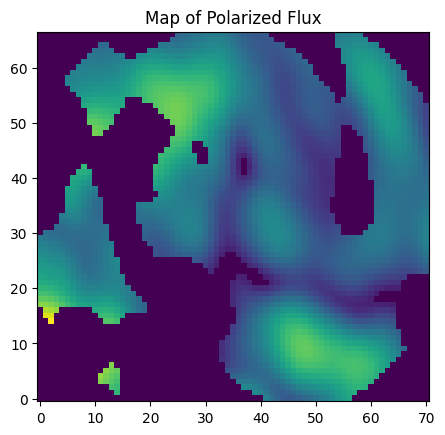

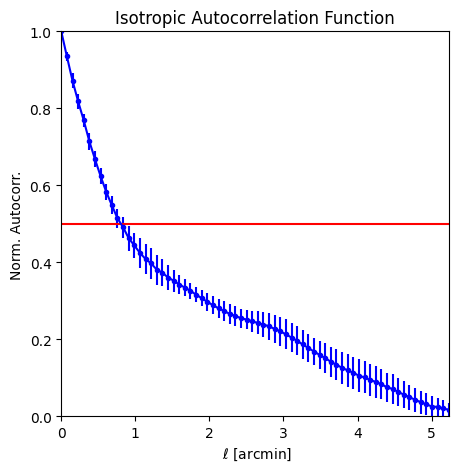

In [20]:
res = dispersion.autocorrelation(p_flux,p_flux_err,pixsize=pixel_size,mask=mask,plots=True,hwhm=True)

In this case, the result is the $\Delta^{\prime}$ in the (multiples of) input units

In [21]:
Delta_p = res[0] # arcmin
u_Delta_p = res[1] # arcmin
print("Delta' = %2.2f +/- %2.2f [arcmin]"%(Delta_p,u_Delta_p))

Delta' = 0.81 +/- 0.06 [arcmin]


The HWHM function interpolates between the two closest points to determine $\Delta^{\prime}$.

By setting *hwhm=False*, you can perform your own plotting and further analysis of the autocorrelation function,

In [22]:
res1 = dispersion.autocorrelation(p_flux,p_flux_err,pixsize=pixel_size,mask=mask,plots=False,hwhm=False)

Text(4.0, 0.9, '$\\Delta^{\\prime}$ = 0.81 $\\pm$ 0.06 [arcmin]')

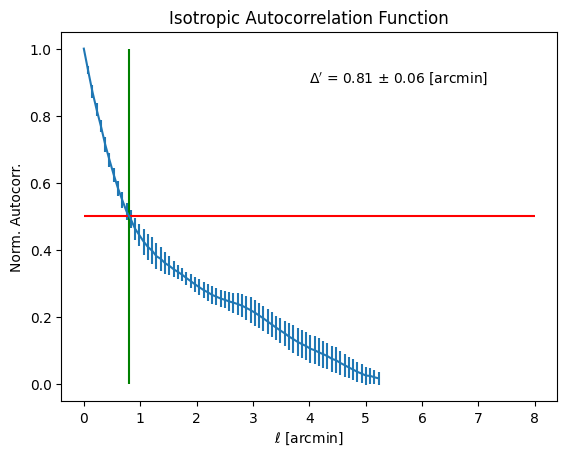

In [23]:
lvals = res1[2] # in arcmin
autocorr = res1[0] # 
autocorr_err = res1[1]
plt.errorbar(lvals,autocorr,yerr=autocorr_err)
plt.xlabel(r'$\ell$ [arcmin]')
plt.ylabel('Norm. Autocorr.')
plt.title('Isotropic Autocorrelation Function')
plt.hlines(0.5,0,8,color='red')
plt.vlines(res[0],0,1,color='green')
plt.text(4.,0.9,r'$\Delta^{\prime}$ = %2.2f $\pm$ %2.2f [arcmin]'%(res[0],res[1]))

Step 3: Calculating the *dispersion function*. We must perform this calculation using the same total mask forconsitency. The inputs for this calaculation are the polarization angle, its uncertainty, and the beam size, in addition to the pixel size

In [25]:
# angles = data['ROTATED POL ANGLE'].data # km/s
# angles = angles[588:656, 994:1066]
# angles_err = data['ERROR POL ANGLE'].data # km/s
# angles_err = angles_err[588:656, 994:1066]
beam_s = 4*pixel_size # FWHM value of the beam -- typical for SOFIA/HAWC+ observations

The dispersion function can be called as

In [23]:
angles.shape

(67, 71)

In [24]:
angles_err.shape

(67, 71)

In [25]:
mask.shape

(67, 71)

In [26]:
res2 = dispersion.dispersion_function(angles,angles_err,pixel_size,mask=mask,beam=beam_s)

Number of vector pairs =  4498500
Calculating Pairs:
Percent: [----------] 0.03333333333333333%  
Percent: [----------] 0.06666666666666667%  
Percent: [----------] 0.1%  
Percent: [----------] 0.13333333333333333%  
Percent: [----------] 0.16666666666666669%  
Percent: [----------] 0.2%  
Percent: [----------] 0.23333333333333336%  
Percent: [----------] 0.26666666666666666%  
Percent: [----------] 0.3%  
Percent: [----------] 0.33333333333333337%  
Percent: [----------] 0.36666666666666664%  
Percent: [----------] 0.4%  
Percent: [----------] 0.4333333333333333%  
Percent: [----------] 0.46666666666666673%  
Percent: [----------] 0.5%  
Percent: [----------] 0.5333333333333333%  
Percent: [----------] 0.5666666666666667%  
Percent: [----------] 0.6%  
Percent: [----------] 0.6333333333333333%  
Percent: [----------] 0.6666666666666667%  
Percent: [----------] 0.7000000000000001%  
Percent: [----------] 0.7333333333333333%  
Percent: [----------] 0.7666666666666666%  
Percent: [------

/users/nsalem/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/users/nsalem/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/users/nsalem/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/users/nsalem/.local/lib/python3.8/site-packages/polBpy/utils.py:113: RuntimeWarning: Mean of empty slice
  rms = np.sqrt(np.nanmean(vec**2))


Percent: [#---------] 5.063291139240507%  
Percent: [#---------] 6.329113924050633%  
Percent: [#---------] 7.59493670886076%  
Percent: [#---------] 8.860759493670885%  
Percent: [#---------] 10.126582278481013%  
Percent: [#---------] 11.39240506329114%  
Percent: [#---------] 12.658227848101266%  
Percent: [#---------] 13.924050632911392%  
Percent: [##--------] 15.18987341772152%  
Percent: [##--------] 16.455696202531644%  
Percent: [##--------] 17.72151898734177%  
Percent: [##--------] 18.9873417721519%  
Percent: [##--------] 20.253164556962027%  
Percent: [##--------] 21.518987341772153%  
Percent: [##--------] 22.78481012658228%  
Percent: [##--------] 24.050632911392405%  
Percent: [###-------] 25.31645569620253%  
Percent: [###-------] 26.582278481012654%  
Percent: [###-------] 27.848101265822784%  
Percent: [###-------] 29.11392405063291%  
Percent: [###-------] 30.37974683544304%  
Percent: [###-------] 31.645569620253166%  
Percent: [###-------] 32.91139240506329%  
Per

The result is a list containing the following: 0) $\ell^{2}$ values, 1) dispersion function, 2) dispersion uncertainties. 

Text(0, 0.5, '$1-\\langle \\cos(\\Delta\\phi)\\rangle$')

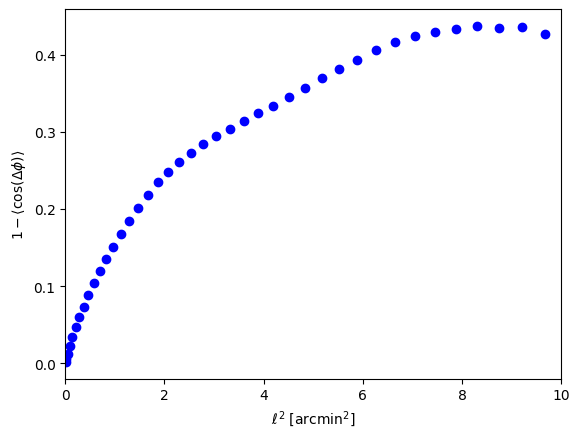

In [27]:
l = res2[0] # \ell values in arcsec^2
disp_f = res2[1] # Dispersion function
disp_f_err = res2[2] # Dispersion function uncertainty
#
# Plot the dispersion function as a function of \ell^2
plt.errorbar(l/3600.,disp_f,yerr=disp_f_err,fmt='bo') # Divide l by 3600 to plot in arcmin^{2}
plt.xlim([0.,10.])
plt.xlabel(r'$\ell^{2}$ [arcmin$^{2}$]')
# plt.ylim([0.,0.3])
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')

Text(0, 0.5, '$1-\\langle \\cos(\\Delta\\phi)\\rangle$')

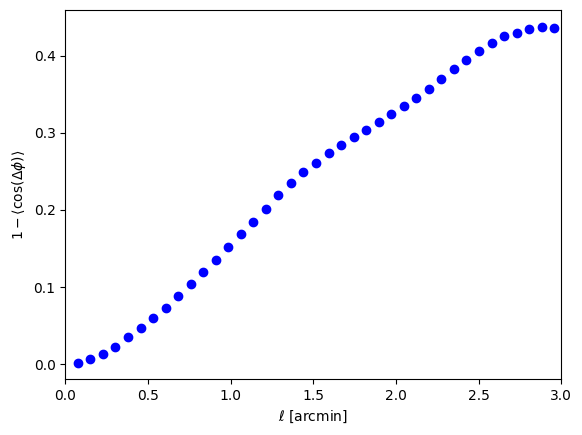

In [28]:
# Plot the dispersion function as a function of \ell
l_ = np.sqrt(l)/60.
plt.errorbar(l_,disp_f,yerr=disp_f_err,fmt='bo')
plt.xlim([0.,3.0])
plt.xlabel(r'$\ell$ [arcmin]')
# plt.ylim([0.,0.3])
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')

The dispersion function can be fitted with the two-scale model (See Houde+09), using the *mcmc_fit* function. For this fitting process, it is necessary to specify the maximum value of $\ell^2$ to consider (e.g., where the dispersion function stops being $\propto\ell^{2}$.

In [29]:
lmax = 6.0*3600. # arcsec^2
res3 = fitting.mcmc_fit(disp_f,l,disp_f_err,lmax=lmax,beam=beam_s,a2=1.0E-3,delta=30.,f=100.,num=400)

Entering the Fitting function
First run -- Uninflatted errors...
Second run -- Inflating errors by Chi value =  17.339890040471637
Done with MCMC fitting.


Three parameters are obtained from this fitting routine: the large-scale contribution coefficient ($a_{2}$), the turbulence's correlation length ($\delta$), and the product $\Delta^{\prime}[\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle]^{-1}$. The result from *mcmc_fit* is a dictionary with keywords *a*, *d*, *f*, and *chi* for these three paramneters, respectively, and the goodnes-of-fit parameter $\chi$,

In [30]:
a2 = res3['a']*3600. # Units of arcmin^{-2}
print("a_2 = %2.3E [arcmin^-2]"%a2)

a_2 = 3.103E-02 [arcmin^-2]


In [31]:
delta = res3['d']
print("delta = %2.2f [arcsec]"%delta)

delta = 42.53 [arcsec]


In [32]:
ratio = res3['f']
print("ratio = %2.2f [arcsec]"%ratio)

ratio = 374.13 [arcsec]


From ratio, we calculate $\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle$ using the value of $\Delta^{\prime}$ as

In [33]:
Bt2_B02 = (Delta_p*60)/res3['f']
print("Bt2_B02 = %2.2f"%Bt2_B02)

Bt2_B02 = 0.13


With these values we can evaluate the function and overplot the fit over the dispersion function for visual confirmation. We can call the the model from the fitting module

In [34]:
lvec = np.arange(60000) # a vector array in arcsec^2
f = fitting.model_funct(l,(a2/3600.),delta,ratio,beam=beam_s) # This function reads in ratio and not Bt2_B02

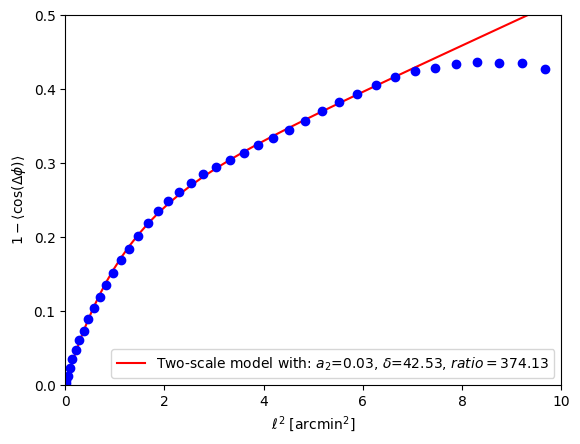

In [35]:
# Plot the dispersion function as a function of \ell^2
# Multiply the uncertainties by the chi value
plt.errorbar(l/3600.,disp_f,yerr=res3['chi']*disp_f_err,fmt='bo')
label = r'Two-scale model with: $a_{2}$=%2.2f, $\delta$=%2.2f, $ratio=$%2.2f'%(a2,delta,ratio)
plt.plot(l/3600., f,c='red',label=label)
plt.xlim([0.,10.])
plt.xlabel(r'$\ell^{2}$ [arcmin$^{2}$]')
plt.ylim([0.,0.5])
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')
plt.legend()

Using the value of $\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle$, along with the reportted values on Butterfield+2024, the $B_{\rm POS}$ value can be calculated following the procedures of Tutorial I.